# **Database Monitoring Script - Cocaine Seizures 2025 (Google Sheets)**
#### InSight Crime - MAD Unit 
June, 2025

##### Luis Felipe Villota Macías

---------------------



### Project Setup

#### Version Control

The project is created within a single GitHub repository ([FelipeVillota/db-check-cocaine-seizures](https://github.com/FelipeVillota/db-check-cocaine-seizures)). I keep the repository `private` with the possibility to give access to the online repo at any time. 

#### Reproducible Environment

In [14]:
# IMPORTANT
# To create venv
# python -m venv venv-db-watch

# To activate environment, run in Terminal:
# # (optional, temporary auth) 
# Set-ExecutionPolicy -Scope Process -ExecutionPolicy Bypass 
# venv-db-watch\Scripts\activate

# Then select respective kernel --> also install ipykernel package to connect to kernel

# Update list master list
# pip freeze > requirements.txt

In [2]:
# Checking venv-db-watch works
import sys
print(sys.executable)

c:\Users\USER\Desktop\ic\db-check-cocaine-seizures\venv-db-watch\Scripts\python.exe


#### Loading Libraries

In [16]:
# pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib pandas

In [3]:
import os
import re
import requests
import pandas as pd
from datetime import datetime
from google.oauth2 import service_account
from googleapiclient.discovery import build
import gspread
from google.oauth2.service_account import Credentials
from gspread_formatting import format_cell_ranges, CellFormat, Color
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# pip freeze > requirements.txt

### Accessing the API

This creates a modular client (frontend) call that is able to extract the desired subset of data from the API server (backend); -and, make it easily reusable for future queries.


In [4]:
# Configure Google Drive API

# Path to your service account key file
SERVICE_ACCOUNT_FILE = 'C:/Users/USER/Desktop/ic/llavero/summer-sector-439022-v6-2eafffbbfb90.json' # Update with the actual path or team credentials file

# Original (latest maintained) Google Sheet ID
ORIGINAL_SPREADSHEET_ID =  '1t61MafCmnRe2QN082Bk1V0IxBSIW8UUqH1g5mULgb2o'  # Update with the actual Google Sheet ID

# Define the sheet tab or range to read
RANGE_NAME = '2025'

# Define scopes for Google Sheets and Drive API
SCOPES = ['https://www.googleapis.com/auth/spreadsheets', 
          'https://www.googleapis.com/auth/drive']


In [5]:
# Authenticate and build both Sheets and Drive services
creds = service_account.Credentials.from_service_account_file(
    SERVICE_ACCOUNT_FILE, scopes=SCOPES)
sheet_service = build('sheets', 'v4', credentials=creds)
drive_service = build('drive', 'v3', credentials=creds)


In [6]:
#====== RUN ONLY FOR TESTS =========
 
# Create a copy of the original spreadsheet in Google Drive. 

# Create dated title for demo/test copy
today_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
copy_title = f'Validation Test - {today_str}'

# Create a copy with today's date
copy_body = {'name': copy_title, 'parents': ['root']}
copied_file = drive_service.files().copy(
    fileId=ORIGINAL_SPREADSHEET_ID,
    body=copy_body
).execute()

# Use the ID of the new copy for analysis
SPREADSHEET_ID = copied_file['id']

# Share with a personal Google account
drive_service.permissions().create(
    fileId=SPREADSHEET_ID,
    body={
        'type': 'user',
        'role': 'writer',
        'emailAddress': 'lvillota@insightcrime.org' 
    },
    fields='id'
).execute()

print(f"✅ Spreadsheet copied on {today_str}. New ID: {SPREADSHEET_ID}")

# URL
print(f"https://docs.google.com/spreadsheets/d/{SPREADSHEET_ID}")


✅ Spreadsheet copied on 2025-06-19 15:56:40. New ID: 1_4sGaWJmX-XfPG6x7NxutXQ3K4DHCEUPoCAFzvF9IbI
https://docs.google.com/spreadsheets/d/1_4sGaWJmX-XfPG6x7NxutXQ3K4DHCEUPoCAFzvF9IbI


In [7]:
# Load data
 
# Call the Sheets API to read data
sheet = sheet_service.spreadsheets()
result = sheet.values().get(spreadsheetId=SPREADSHEET_ID, range=RANGE_NAME).execute()
values = result.get('values', [])

# Convert to DataFrame for easier manipulation
df = pd.DataFrame(values[1:], columns=values[0])
print(df.head()) 

      Type   Time unit        Date Date 2  Year Month Day Duration  \
0  Seizure  Individual  2025-03-24         2025     3  24            
1  Seizure  Individual  2025-03-23         2025     3  23            
2  Seizure  Individual  2025-03-22         2025     3  22            
3  Seizure  Individual  2025-03-22         2025     3  22            
4  Seizure  Individual  2025-03-19         2025     3  19            

                       Type Drugs Quantity  ... Destition - department.state  \
0                         Cocaine       10  ...                                
1                         Cocaine      2.5  ...                                
2                         Cocaine     2619  ...                                
3  Other (explain in Description)     1240  ...                                
4                         Cocaine    16.05  ...                                

  Destition - Municipality/Port Destition 2 - Country  \
0                                        

### Execution

#### Pre-processing

In [8]:
# Handle Missing/Invalid Values
 
df = df.replace('', pd.NA)  # Convert empty strings to NA
df = df.replace(r'^\s*$', pd.NA, regex=True)  # Convert whitespace to NA
print("✓ Converted empty strings/whitespace to NA values")

✓ Converted empty strings/whitespace to NA values


In [9]:
# Indentify Existing Dropdowns
 
def get_sheet_dropdowns(spreadsheet_id, sheet_name, creds):
    service = build('sheets', 'v4', credentials=creds)
    sheet_metadata = service.spreadsheets().get(
        spreadsheetId=spreadsheet_id,
        ranges=[sheet_name],
        includeGridData=True
    ).execute()

    dropdowns_by_column = {}

    for sheet in sheet_metadata['sheets']:
        if sheet['properties']['title'] != sheet_name:
            continue

        col_dropdowns = {}
        rows = sheet['data'][0]['rowData']
        header_row = rows[0]['values']
        col_names = [cell.get('formattedValue', f"Column_{i}") for i, cell in enumerate(header_row)]

        for col_idx, col_name in enumerate(col_names):
            dropdowns_in_col = set()
            for row in rows[1:]:  # Skip header
                cell = row['values'][col_idx]
                if 'dataValidation' in cell:
                    dv = cell['dataValidation']
                    if dv['condition']['type'] == 'ONE_OF_LIST':
                        values = [v['userEnteredValue'] for v in dv['condition']['values']]
                        dropdowns_in_col.update(values)
            if dropdowns_in_col:
                col_dropdowns[col_name] = list(dropdowns_in_col)

        dropdowns_by_column.update(col_dropdowns)

    return dropdowns_by_column

dropdown_options = get_sheet_dropdowns(SPREADSHEET_ID, '2025', creds)

# Print results
for col, options in dropdown_options.items():
    print(f"🔽 {col}: {options}")


🔽 Type: ['Total Crop Cultivation Estimate', 'Price', 'Crop Eradication', 'Total Production Estimate', 'Seizure', 'Other (explain in Description)']
🔽 Time unit: ['Individual', 'Year', 'Multi-Month', 'Other (explain in Description)', 'Month', 'Multi-Year']
🔽 Type Drugs: ['All/Unspecified/Multiple', 'Cocaine Base', 'Cocaine', 'Other (explain in Description)', 'Coca Crops', 'Cocaine - Crack']
🔽 Weight unit: ['Pounds (lbs)', 'Other currency (say which in Description)', 'Pounds (£)', 'Kilogram', 'Percent', 'USD', 'Other (explain in Description)', 'Euro', 'Plant', 'Hectare', 'Package']
🔽 Modus Operandi/place of seizure: ['Maritime vessel', 'River vessel', 'Container', 'Air', 'Land']
🔽 Region: ['Europe', 'Central America', 'Global', 'Caribbean', 'Oceania', 'Africa', 'South America', 'North America', 'Asia']
🔽 Origin country: ['Colombia', '""', 'Peru', 'Bolivia']
🔽 Transit 1/Region: ['Europe', 'Central America', 'Global', 'Caribbean', 'Oceania', 'Africa', 'South America', 'North America', 'Asia

### Monitoring

##### Summary Stats

In [10]:
def get_dataframe_summary(df):
    # --- General DataFrame Info ---
    general_info = {
        "Shape": f"{df.shape[0]} rows × {df.shape[1]} cols",
        "Memory Usage": f"{df.memory_usage(deep=True).sum() / (1024 ** 2):.2f} MB",
        "Columns with NA": f"{df.isna().any().sum()} / {len(df.columns)}",
        "Duplicate Rows": f"{df.duplicated().sum()} ({(df.duplicated().mean() * 100):.1f}%)",
        "Numeric Columns": f"{df.select_dtypes(include='number').shape[1]}",
        "Categorical Columns": f"{df.select_dtypes(include=['object', 'category']).shape[1]}",
        "Datetime Columns": f"{df.select_dtypes(include='datetime').shape[1]}"
    }

  # --- Compute dropdown options per column ---
    dropdown_options_dict = {
        col: dropdown_options.get(col, [])
        for col in df.columns
    }
    # --- Column-Level Stats ---
    column_stats = pd.DataFrame({
        'Variable': df.columns,
        'Dtype': df.dtypes.values,
        'Unique_Count': df.nunique().values,
        'NA_Count': df.isna().sum().values,
        'NA_Percentage': (df.isna().mean() * 100).round(1).values,
        'Duplicate_Count': df.apply(lambda col: col.duplicated(keep=False).sum()).values,
        'Duplicate_Percentage': (df.apply(lambda col: col.duplicated(keep=False).mean()) * 100).round(1).values,
        'Unique_Values': df.apply(lambda x: x.drop_duplicates().tolist()).values,
        'Dropdown_Options': [dropdown_options_dict[col] for col in df.columns],
        'Dropdown_Option_Count': [len(dropdown_options_dict[col]) for col in df.columns]
    }).sort_values('Unique_Count', ascending=False)


    # Format percentages
    column_stats['NA_Percentage'] = column_stats['NA_Percentage'].astype(str) + '%'
    column_stats['Duplicate_Percentage'] = column_stats['Duplicate_Percentage'].astype(str) + '%'

    return general_info, column_stats

# Run the summary
general_info, column_stats = get_dataframe_summary(df)

# Print General Info
print("=== GENERAL DATAFRAME INFO ===")
for key, value in general_info.items():
    print(f"{key}: {value}")

# Display Column Stats (including dropdown options)
print("\n=== COLUMN-LEVEL STATISTICS ===")
display(column_stats)


=== GENERAL DATAFRAME INFO ===
Shape: 419 rows × 41 cols
Memory Usage: 1.07 MB
Columns with NA: 37 / 41
Duplicate Rows: 0 (0.0%)
Numeric Columns: 0
Categorical Columns: 41
Datetime Columns: 0

=== COLUMN-LEVEL STATISTICS ===


,Variable,Dtype,Unique_Count,NA_Count,NA_Percentage,Duplicate_Count,Duplicate_Percentage,Unique_Values,Dropdown_Options,Dropdown_Option_Count
35,Description,object,416,1,0.2%,4,1.0%,"[Spanish citizen, coming from Lisbon , was sto...",[],0
39,Source link,object,400,1,0.2%,33,7.9%,[https://www.lanazione.it/firenze/cronaca/coca...,[],0
9,Quantity,object,284,3,0.7%,202,48.2%,"[10, 2.5, 2619, 1240, 16.05, 65, 6600, 142, 55...",[],0
17,Municipality/Port,object,264,110,26.3%,187,44.6%,"[Florence, Santo Domingo, Lake Maracaibo , Eag...",[],0
16,Department/State,object,219,36,8.6%,268,64.0%,"[<NA>, Zulia, Texas, Cáceres, Azores, Québec, ...",[],0
11,seizure_kgs,object,217,122,29.1%,250,59.7%,"[9, 2.5, 2619, 1240, 16.05, 65, 6600, 142, 250...",[],0
2,Date,object,94,2,0.5%,402,95.9%,"[2025-03-24, 2025-03-23, 2025-03-22, 2025-03-1...",[],0
24,Transit 1/Municipality,object,72,333,79.5%,358,85.4%,"[<NA>, Matapalo, Rio de Janeiro, Acapulco, Kin...",[],0
23,Transit 1/Department,object,61,321,76.6%,370,88.3%,"[Lisbon, <NA>, Santo Domingo, Paris, Puntarena...",[],0
15,Country,object,50,3,0.7%,399,95.2%,"[Italy, Dominican Republic, Venezuela, United ...",[],0


##### Missing Data Analysis


Missing values per column:
Type                                 0
Time unit                            0
Date                                 2
Date 2                             408
Year                                 2
Month                                2
Day                                  3
Duration                           407
Type Drugs                           0
Quantity                             3
Weight unit                          2
seizure_kgs                        122
Modus Operandi/place of seizure      7
Sub MO                             389
Region                               0
Country                              3
Department/State                    36
Municipality/Port                  110
Origin country                     363
Origin Area                        397
Origin municipality                405
Transit 1/Region                   263
Transit 1/country                  250
Transit 1/Department               321
Transit 1/Municipality             33

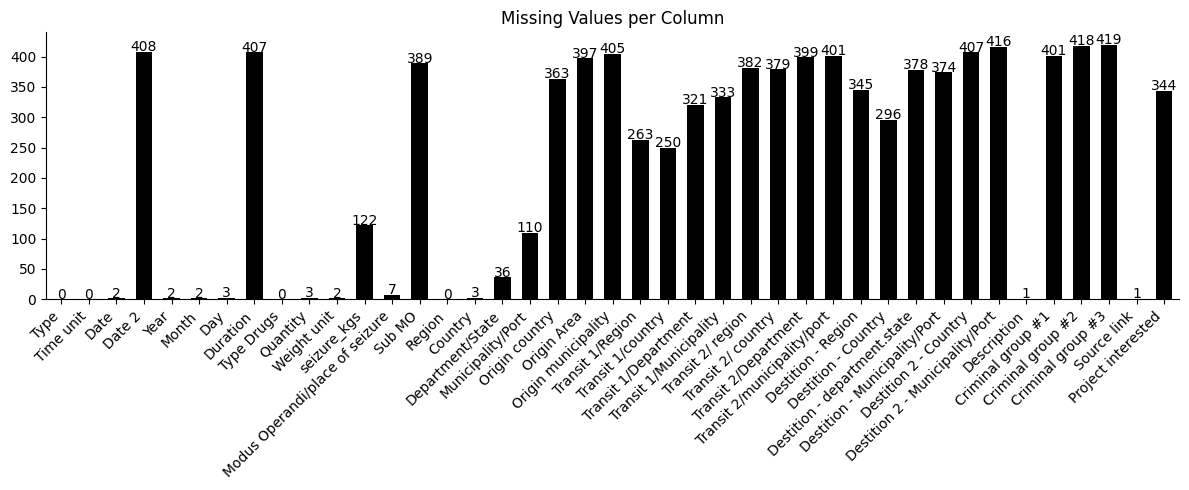

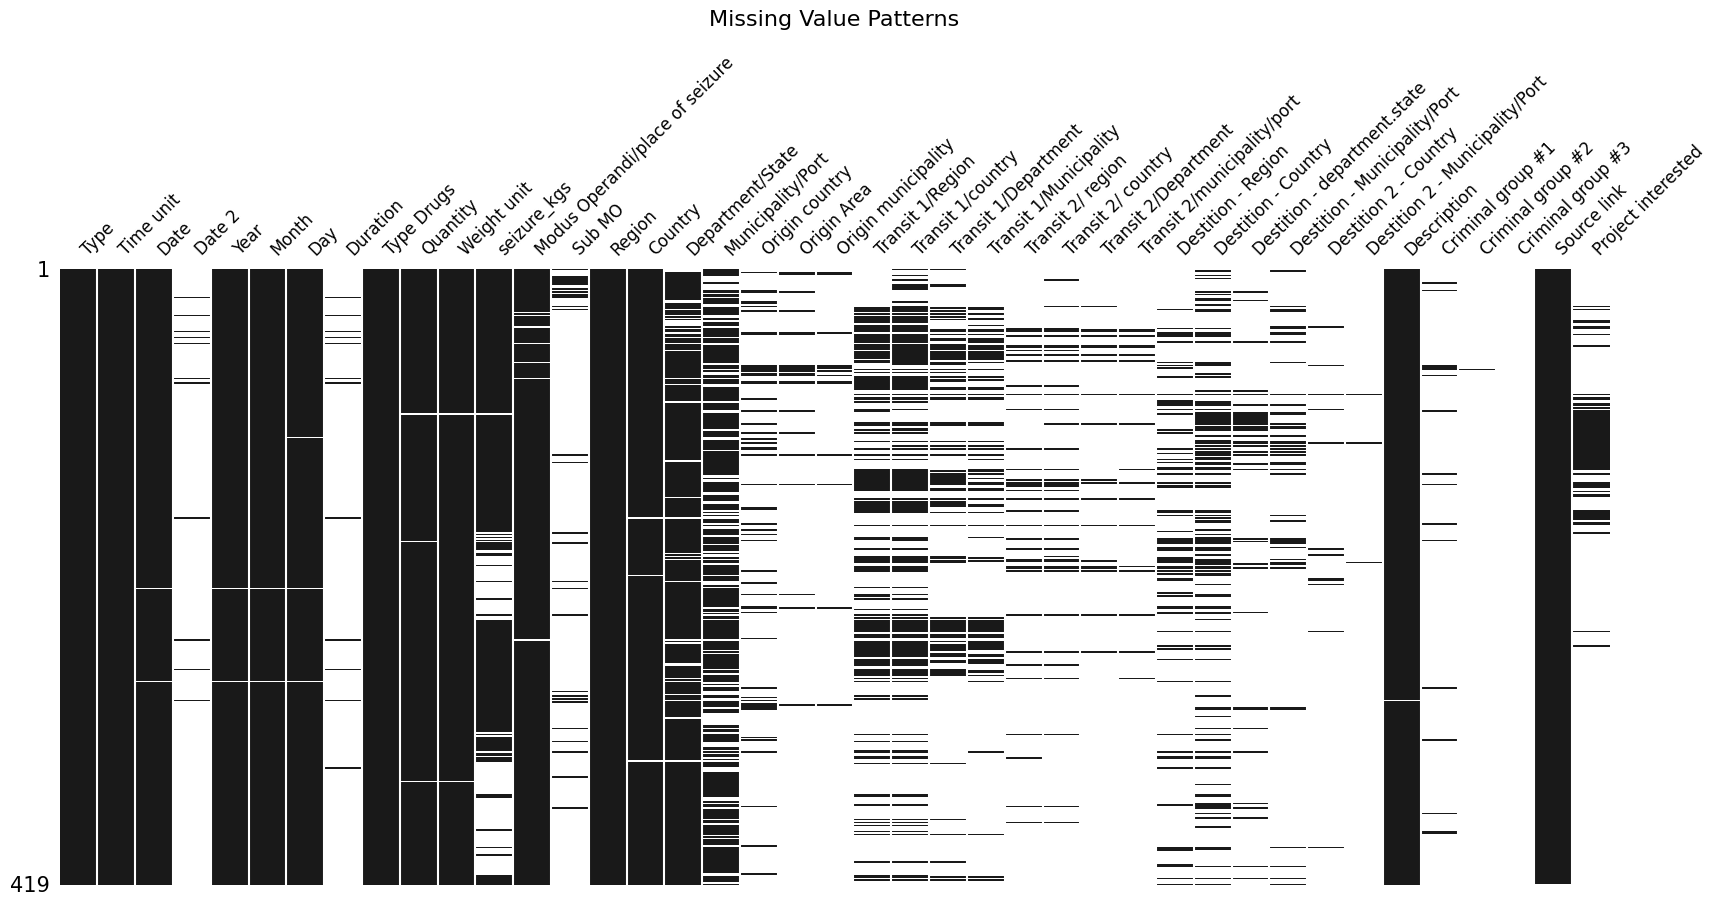

In [11]:

missing_values = df.isnull().sum()
print(f"Missing values per column:\n{missing_values}\n")

# Visualization 1: Bar Chart
plt.figure(figsize=(12, 5))
ax = missing_values.plot(kind='bar', color="#000000", width=0.6)
ax.grid(False)
for i in ax.patches:
    ax.text(i.get_x() + i.get_width()/2, i.get_height()+1, 
            f'{int(i.get_height())}', 
            ha='center', fontsize=10)
plt.xticks(rotation=45, ha='right')
sns.despine()
plt.title("Missing Values per Column")
plt.tight_layout()
plt.show()

# Visualization 2: Missingno Matrix
msno.matrix(
    df,
    figsize=(20, 8),
    color=(0.1, 0.1, 0.1),
    sparkline=False,
    fontsize=12,
    labels=True
)
plt.title("Missing Value Patterns", fontsize=16, pad=20)
plt.show()

##### Flow and proportions

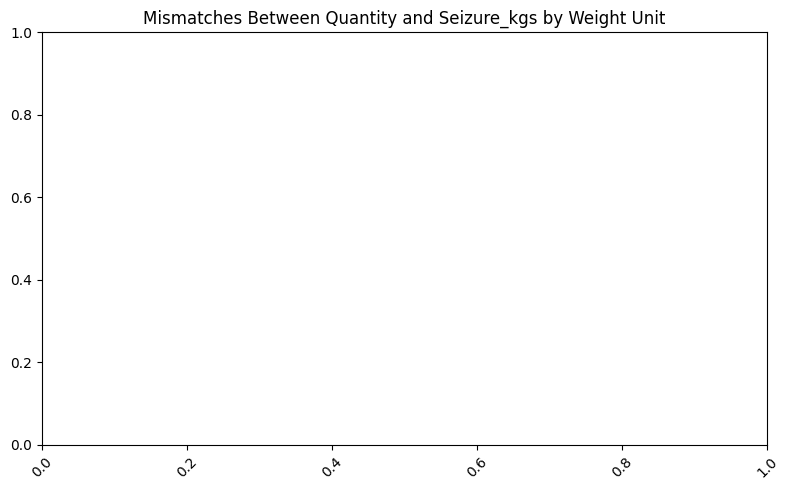

In [39]:
df['kg_unit_mismatch'] = (
    (df['Weight unit'].str.lower() == 'Kilogram') &
    (df['Quantity'] != df['seizure_kgs'])
)

# 2. Count of mismatches by weight unit
unit_mismatch_counts = df[df['kg_unit_mismatch']].groupby('Weight unit').size().reset_index(name='count')

# 3. Plot mismatches
plt.figure(figsize=(8, 5))
sns.barplot(data=unit_mismatch_counts, x='Weight unit', y='count', palette='Reds')
plt.title("Mismatches Between Quantity and Seizure_kgs by Weight Unit")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


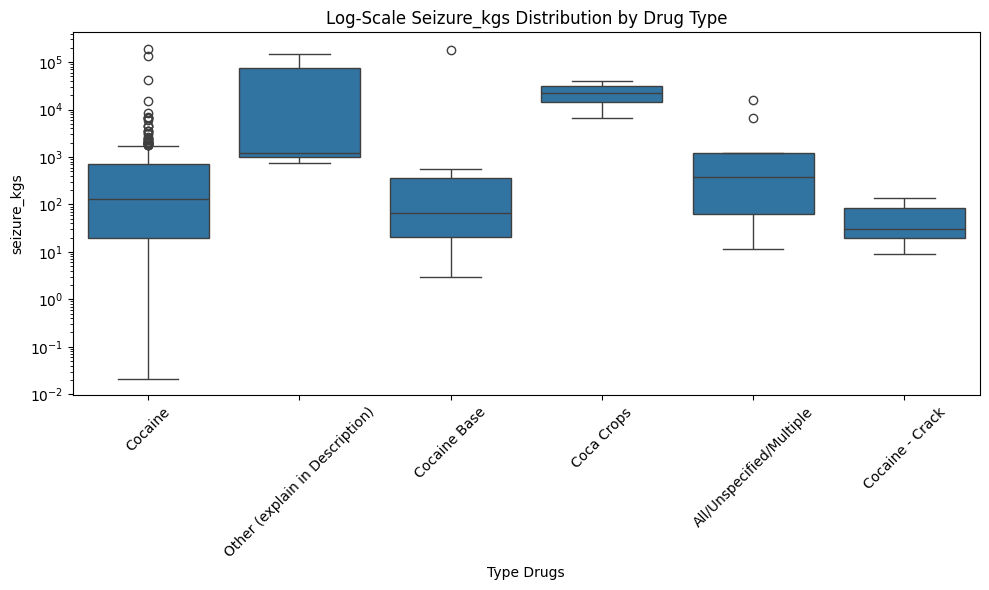

In [63]:
import numpy as np

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Type Drugs', y='seizure_kgs')
plt.yscale('log')
plt.title("Log-Scale Seizure_kgs Distribution by Drug Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


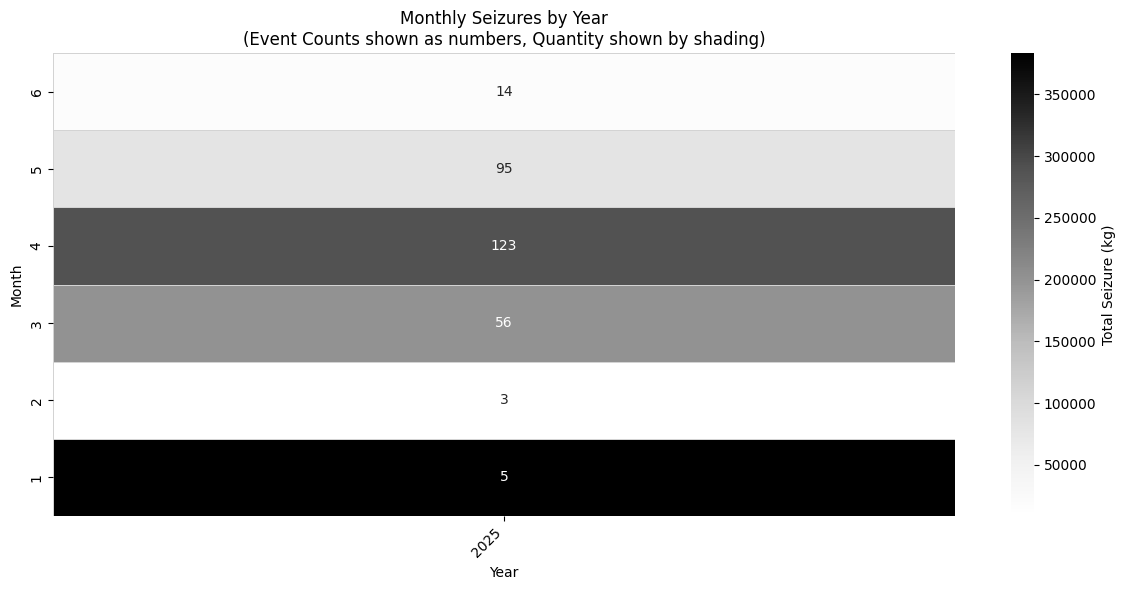

In [56]:
# Convert and clean seizure data
df['seizure_kgs'] = pd.to_numeric(df['seizure_kgs'], errors='coerce')

# Create pivot tables with matching structure
pivot_data = df.groupby(['Year', 'Month']).agg(
    seizure_kg=('seizure_kgs', 'sum'),
    event_count=('seizure_kgs', 'count')
).unstack(level=0)

# Extract components
seizure_kg = pivot_data['seizure_kg']
event_counts = pivot_data['event_count']

# Fill NaN values with 0 if appropriate, or use mask
seizure_kg_filled = seizure_kg.fillna(0)

# Plot combined heatmap
plt.figure(figsize=(12,6))
ax = sns.heatmap(
    seizure_kg_filled.sort_index(ascending=False),
    cmap="Greys",
    annot=event_counts.sort_index(ascending=False),
    fmt='g',
    cbar_kws={'label': 'Total Seizure (kg)'},
    linewidths=0.5,  # Adds grid lines between cells
    linecolor='lightgray'  # Color for grid lines
)

# Title and labels
plt.title("Monthly Seizures by Year\n(Event Counts shown as numbers, Quantity shown by shading)")
plt.ylabel("Month")
plt.xlabel("Year")

# Rotate year labels if needed
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()


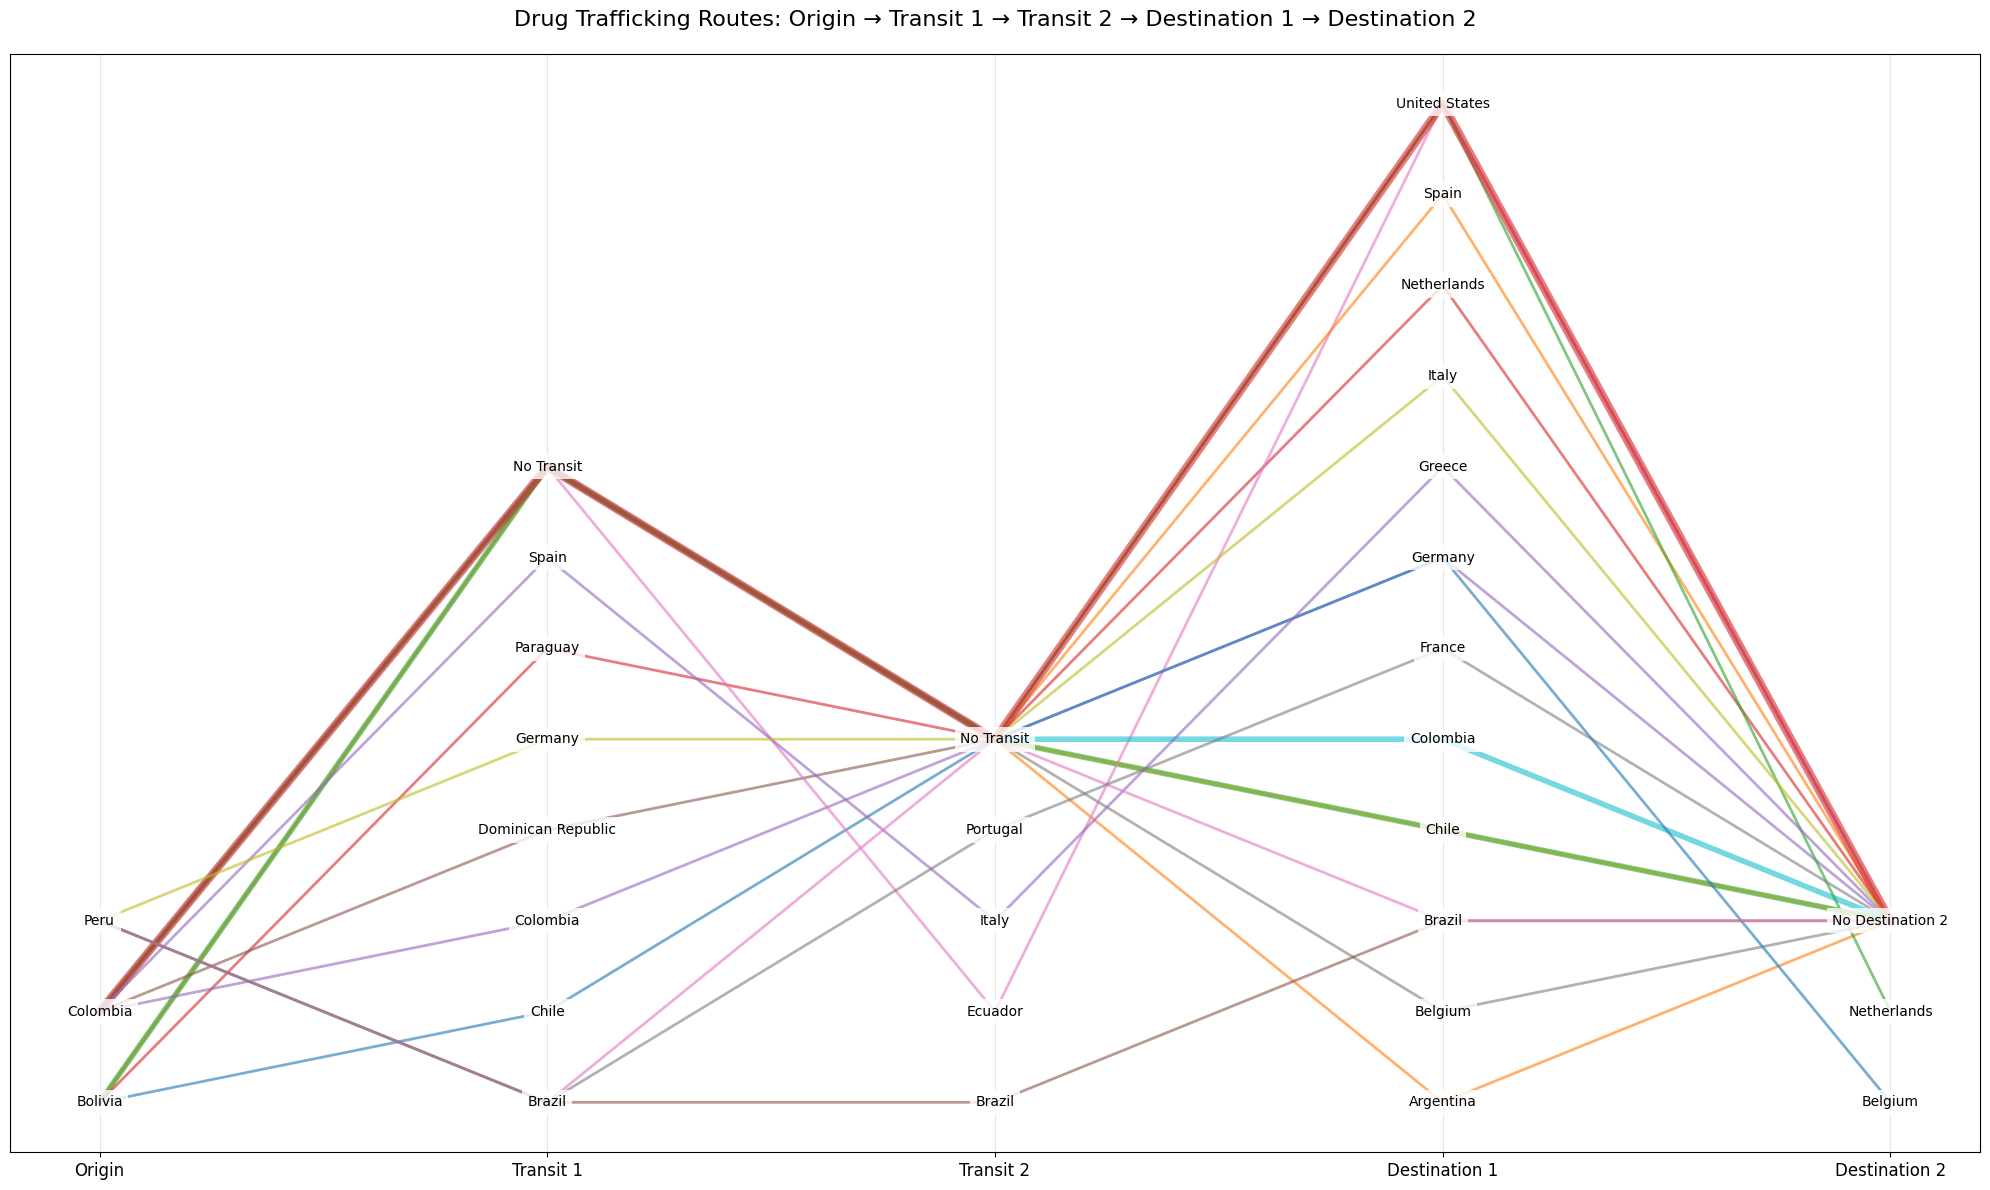

In [35]:
import matplotlib.pyplot as plt

def plot_parallel_sets(df): 
    # Define the column names
    columns = ['Origin country', 'Transit 1/country', 'Transit 2/ country',
               'Destition - Country', 'Destition 2 - Country']
    
    # Copy and fill missing values
    df = df[columns].copy()
    df[columns[1]] = df[columns[1]].fillna('No Transit')
    df[columns[2]] = df[columns[2]].fillna('No Transit')
    df[columns[4]] = df[columns[4]].fillna('No Destination 2')
    
    # Filter incomplete rows
    df.dropna(subset=[columns[0], columns[3]], inplace=True)
    if df.empty:
        print("Warning: No data with both origin and destination information")
        return
    
    # Count path frequencies
    path_counts = df.groupby(columns).size().reset_index(name='count')
    
    # Prepare the plot
    plt.figure(figsize=(20, 12))

    # Map each category to a y-position (starting at 1)
    categories = {}
    for col in columns:
        values = df[col].unique()
        sorted_vals = sorted([v for v in values if "No" not in v]) + sorted([v for v in values if "No" in v])
        categories[col] = {val: idx + 1 for idx, val in enumerate(sorted_vals)}
    
    # Plot each path
    for _, row in path_counts.iterrows():
        y_values = [categories[col][row[col]] for col in columns]
        plt.plot(range(len(columns)), y_values, linewidth=row['count'] * 2, alpha=0.6)

    # X-axis: step names
    plt.xticks(range(len(columns)), ['Origin', 'Transit 1', 'Transit 2', 'Destination 1', 'Destination 2'], fontsize=12)
    
    # Y-axis: remove default numbers
    plt.yticks([])
    
    # Add node labels
    for i, col in enumerate(columns):
        for val, y in categories[col].items():
            plt.text(i, y, val, ha='center', va='center',
                     bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'), fontsize=10)
    
    # Final touches
    plt.title("Drug Trafficking Routes: Origin → Transit 1 → Transit 2 → Destination 1 → Destination 2", 
              fontsize=16, pad=20)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_parallel_sets(df)

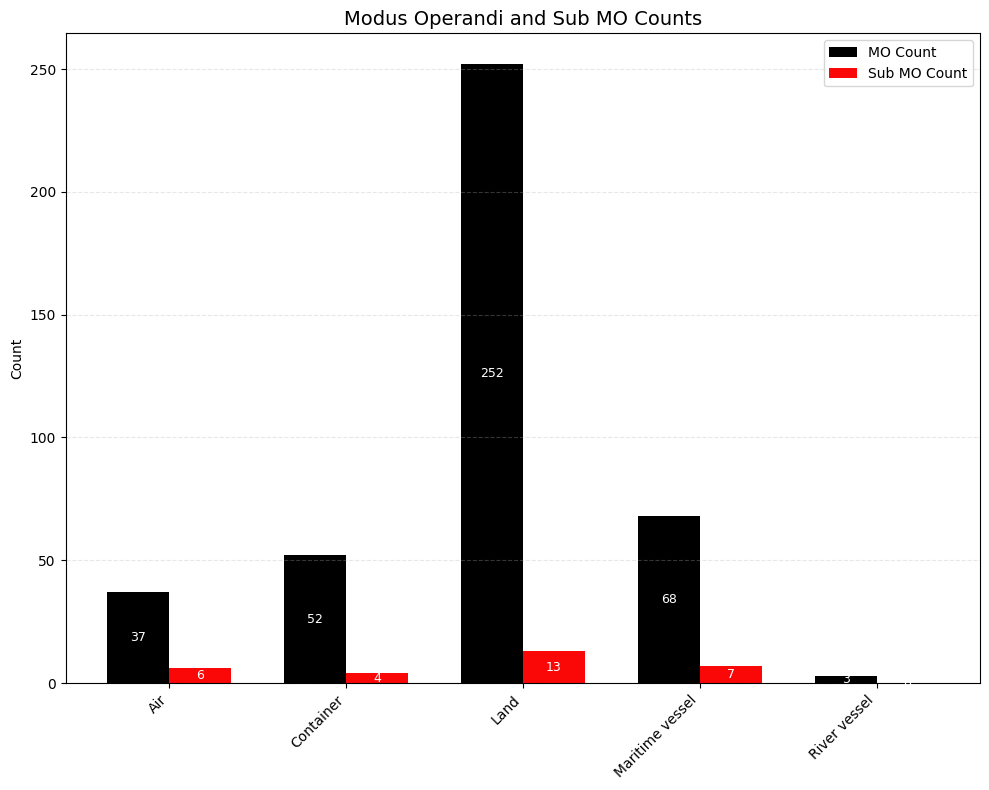

In [65]:
import numpy as np

# Group counts
mo = df['Modus Operandi/place of seizure'].value_counts().sort_index()
sub_mo = df.groupby('Modus Operandi/place of seizure')['Sub MO'].count().reindex(mo.index)

# Plot
labels = mo.index
x = np.arange(len(labels))
w = 0.35

fig, ax = plt.subplots(figsize=(10, 8))
b1 = ax.bar(x - w/2, mo, w, label='MO Count', color="#000000")
b2 = ax.bar(x + w/2, sub_mo, w, label='Sub MO Count', color="#FA0707")

# Label bars
for bars in [b1, b2]:
    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
                str(int(bar.get_height())), ha='center', va='center', color='white', fontsize=9)

# Style
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_title('Modus Operandi and Sub MO Counts', fontsize=14)
ax.legend()
ax.set_ylabel('Count')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.show()



### Validation

In [26]:
# Date must not be empty
def validate_dates(df, date_column='Date'):
    if date_column not in df.columns:
        print(f"❌ Column '{date_column}' not found")
        return
    
    # Check for empty dates
    empty_dates = df[df[date_column].isna()]
    
    if not empty_dates.empty:
        print(f"❌ Found {len(empty_dates)} rows with empty '{date_column}' dates:")
        print(empty_dates)
    else:
        print(f"✅ All '{date_column}' dates are filled")


validate_dates(df)

❌ Found 2 rows with empty 'Date' dates:
        Type   Time unit  Date Date 2  Year Month   Day Duration Type Drugs  \
217  Seizure  Individual  <NA>   <NA>  <NA>  <NA>  <NA>     <NA>    Cocaine   
280  Seizure  Individual  <NA>   <NA>  <NA>  <NA>  <NA>     <NA>    Cocaine   

    Quantity  ... Destition - department.state Destition - Municipality/Port  \
217      120  ...                         <NA>                          <NA>   
280        3  ...                         <NA>                          <NA>   

    Destition 2 - Country Destition 2 - Municipality/Port  \
217                  <NA>                            <NA>   
280                  <NA>                            <NA>   

                                           Description Criminal group #1  \
217  En los puertos de Marín y Vigo (Pontevedra), l...              <NA>   
280  Un poco más de 3 kilos de cocaína serían envia...              <NA>   

    Criminal group #2 Criminal group #3  \
217              <NA>    

In [27]:
# Why is there Duration if there is no Date 2?  
def validate_duration(df, date_column='Date', date2_column='Date 2', duration_column='Duration'):
    if date_column not in df.columns or date2_column not in df.columns or duration_column not in df.columns:
        print(f"❌ One or more columns '{date_column}', '{date2_column}', or '{duration_column}' not found")
        return
    
    # Check for rows where Date 2 is empty but Duration is filled
    invalid_rows = df[(df[date2_column].isna()) & (df[duration_column].notna())]
    
    if not invalid_rows.empty:
        print(f"❌ Found {len(invalid_rows)} rows with '{duration_column}' filled but '{date2_column}' empty:")
        print(invalid_rows)
    else:
        print(f"✅ All '{duration_column}' values are valid with respect to '{date2_column}'")

validate_duration(df)

❌ Found 1 rows with 'Duration' filled but 'Date 2' empty:
        Type    Time unit        Date Date 2  Year Month Day   Duration  \
339  Seizure  Multi-Month  2025-06-03   <NA>  2025     6   3  10 months   

    Type Drugs Quantity  ... Destition - department.state  \
339    Cocaine      187  ...                         <NA>   

    Destition - Municipality/Port Destition 2 - Country  \
339                          <NA>                  <NA>   

    Destition 2 - Municipality/Port  \
339                            <NA>   

                                           Description Criminal group #1  \
339  El 13 de mayo de 2025, en Alsacia, Francia, la...              <NA>   

    Criminal group #2 Criminal group #3  \
339              <NA>              <NA>   

                                           Source link Project interested  
339  https://www.francebleu.fr/infos/faits-divers-j...               None  

[1 rows x 41 columns]


In [28]:
# Check if Date 2 is filed, then Time unit is not Individual
def validate_time_unit(df, date2_column='Date 2', time_unit_column='Time unit'):
    if date2_column not in df.columns or time_unit_column not in df.columns:
        print(f"❌ One or more columns '{date2_column}' or '{time_unit_column}' not found")
        return
    
    # Check for rows where Date 2 is filled but Time unit is 'Individual'
    invalid_rows = df[(df[date2_column].notna()) & (df[time_unit_column] == 'Individual')]
    
    if not invalid_rows.empty:
        print(f"❌ Found {len(invalid_rows)} rows with '{time_unit_column}' as 'Individual' but '{date2_column}' filled:")
        print(invalid_rows)
    else:
        print(f"✅ All '{time_unit_column}' values are valid with respect to '{date2_column}'") 

validate_time_unit(df)



❌ Found 2 rows with 'Time unit' as 'Individual' but 'Date 2' filled:
       Type   Time unit        Date      Date 2  Year Month Day Duration  \
42  Seizure  Individual  2025-03-30  2025-03-31  2025     3  30        1   
46  Seizure  Individual  2025-03-27  2025-04-01  2025     3  27        5   

                  Type Drugs Quantity  ... Destition - department.state  \
42                   Cocaine      152  ...                         <NA>   
46  All/Unspecified/Multiple      875  ...                         <NA>   

   Destition - Municipality/Port Destition 2 - Country  \
42                          <NA>                  <NA>   
46                          <NA>                  <NA>   

   Destition 2 - Municipality/Port  \
42                            <NA>   
46                            <NA>   

                                          Description Criminal group #1  \
42  Autoridades argentinas detuvieron un camión en...              <NA>   
46  En una operación realizada duran

#### Demos

In [165]:
# Update a column name directly in Google Sheets
def update_column_name(old_name, new_name):
    # Get headers
    headers = sheet.values().get(spreadsheetId=SPREADSHEET_ID, range='2025!1:1').execute()['values'][0]
    
    # Find and update column
    if old_name in headers:
        col_index = headers.index(old_name)
        col_letter = chr(65 + col_index)  # Convert to A, B, C...
        
        # Update in sheet
        sheet.values().update(
            spreadsheetId=SPREADSHEET_ID,
            range=f'2025!{col_letter}1',
            valueInputOption='RAW',
            body={'values': [[new_name]]}
        ).execute()
        
        print(f"✅ '{old_name}' → '{new_name}'")
    else:
        print(f"❌ '{old_name}' not found")

# Function usage
update_column_name('Type', 'TIPO')

# Refresh DataFrame
result = sheet.values().get(spreadsheetId=SPREADSHEET_ID, range=RANGE_NAME).execute()
values = result.get('values', [])
df = pd.DataFrame(values[1:], columns=values[0])

❌ 'Type' not found


In [166]:
# Format dates directly in Google Sheets
def format_dates(date_column_name='Date'):
    # Get all data
    result = sheet.values().get(spreadsheetId=SPREADSHEET_ID, range=RANGE_NAME).execute()
    values = result.get('values', [])
    
    if not values:
        print("❌ No data found")
        return
    
    headers = values[0]
    if date_column_name not in headers:
        print(f"❌ '{date_column_name}' column not found")
        return
    
    col_index = headers.index(date_column_name)
    col_letter = chr(65 + col_index)
    
    # Process dates
    updated_values = []
    for i, row in enumerate(values[1:], 2):  # Start from row 2
        if col_index < len(row) and row[col_index]:
            try:
                # Parse date (assuming YYYY-MM-DD format)
                date_obj = datetime.strptime(row[col_index], "%Y-%m-%d")
                # Format to DD-MM-YYYY
                formatted_date = date_obj.strftime("%d-%m-%Y")
                updated_values.append([formatted_date])
            except ValueError:
                # Keep original if can't parse
                updated_values.append([row[col_index]])
        else:
            updated_values.append([''])
    
    # Update the entire date column
    if updated_values:
        sheet.values().update(
            spreadsheetId=SPREADSHEET_ID,
            range=f'2025!{col_letter}2:{col_letter}{len(updated_values)+1}',
            valueInputOption='RAW',
            body={'values': updated_values}
        ).execute()
        
        print(f"✅ Dates formatted to DD-MM-YYYY in column {col_letter}")

# Function usage
format_dates('Date')  # or whatever your date column is called

✅ Dates formatted to DD-MM-YYYY in column C


# What can we do right now?

- MAD service account
- Tool in IC/MAD Unit Github
- Perphaps tell the team in charge of populating the spreadsheet we are going to start a weekly monitoring, and might get notifications in the channel 
- Correct errors in dropdowns 
- Standardize column names
- Systematic flags of erroneous entries and/or missing data (ex: red cells) -> start with event metadata (ex: time units, etc...) -> next week, complete quantities...until all vars are covered. 
- Add as dropdown options the shared list of countries and regions
- Perhaps decide on key visualizations as base monitoring

